In [3]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Activation, Dropout
from tensorflow.keras.regularizers import L1L2
importlib.reload(u)

Using TensorFlow backend.


<module 'dataloader' from '..\\dataloader.py'>

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [5]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases = datadict['cases_calibrated']
deaths = datadict['deaths_calibrated']

In [6]:
demographics = u.load_demographics_data()
demographics.head()

,FIPS,total_pop,60plus,area,median_age,pop_white,pop_black,pop_hispanic,pop_density,p60_plus
0,1001,55036,10523,594.44,37.8,76.9,19.1,2.8,92.584617,0.191202
1,1003,203360,53519,1589.78,42.8,86.3,9.5,4.5,127.917070,0.263174
2,1005,26201,6150,884.88,39.9,47.4,47.6,4.3,29.609665,0.234724
3,1007,22580,4773,622.58,39.9,76.7,22.3,2.4,36.268431,0.211382
4,1009,57667,13600,644.78,40.8,95.5,1.5,9.1,89.436707,0.235837


In [7]:
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
cases_norm = cases / pop * 10000
deaths_norm = deaths / pop * 10000

In [8]:
def transform(x):
    x0 = np.expand_dims(x[:, 0], axis=1)
    t = np.diff(x)
    t0 = np.expand_dims(t[:, 0], axis=1)
    t = np.diff(t)
    return t, t0, x0

In [9]:
def untransform(t, t0, x0, a=1):
    x = np.hstack([t0, t])
    x = np.cumsum(x, axis=a)
    x = np.hstack([x0, x])
    x = np.cumsum(x, axis=a)
    return x

In [10]:
cases2, ct0, cx0 = transform(cases_norm)
deaths2, dt0, dx0 = transform(deaths_norm)

In [11]:
X_train = []
y_train = []
X_test = []
y_test = []
lag = 7
k = 7
validation_steps = 9
for j in range(deaths2.shape[0]):
    d = deaths2[j]
    c = cases2[j]
    if np.all(np.isnan(d)) or np.all(np.isnan(c)):
        continue
    s = np.argmax(np.isnan(d))
    for i in range(s):
        if np.any(np.isnan(d[i:i+lag+k])) or np.any(np.isnan(c[i:i+lag+k])):
            break
        x = np.vstack([c[i:i+lag], d[i:i+lag], np.full((lag,), i)]).T
        if i <= s - validation_steps - lag - k:
            X_train.append(x)
            y_train.append(np.vstack([c[i+lag:i+lag+k], d[i+lag:i+lag+k]]).T)
        else:
            X_test.append(x)
            y_test.append(np.vstack([c[i+lag:i+lag+k], d[i+lag:i+lag+k]]).T)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(18125, 7, 3) (18125, 7, 2) (15820, 7, 3) (15820, 7, 2)


In [18]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=X_train.shape[1:], activation='relu', return_sequences=True, recurrent_regularizer=L1L2(0,1e-2), kernel_regularizer=L1L2(0, 0.1)))
    model.add(Dropout(0.1))
    model.add(TimeDistributed(Dense(2, kernel_regularizer=L1L2(0.1, 0.1))))
    return model

In [19]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)

with tf.device('/GPU:0'):
    model = LSTM_model()
model.compile(loss='mse', optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 64)             17408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 2)              130       
Total params: 17,538
Trainable params: 17,538
Non-trainable params: 0
_________________________________________________________________


In [30]:
import models
importlib.reload(models)

<module 'models' from '..\\models.py'>

In [31]:
model = models.standard_LSTM(X_train, y_train, dropout=0.1, optimizer= opt)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 7, 3)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 64)             17408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 7, 2)              130       
Total params: 17,538
Trainable params: 17,538
Non-trainable params: 0
_________________________________________________________________


In [32]:
with tf.device('/GPU:0'):
    model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=True)

Epoch 1/50
252/252 - 4s - loss: 5.2919 - val_loss: 12.5459
Epoch 2/50
252/252 - 4s - loss: 5.1326 - val_loss: 12.3278
Epoch 3/50
252/252 - 4s - loss: 5.0534 - val_loss: 12.1982
Epoch 4/50
252/252 - 4s - loss: 4.9996 - val_loss: 12.1114
Epoch 5/50
252/252 - 4s - loss: 4.9607 - val_loss: 12.0488
Epoch 6/50
252/252 - 4s - loss: 4.9266 - val_loss: 11.9996
Epoch 7/50
252/252 - 4s - loss: 4.8999 - val_loss: 11.9599
Epoch 8/50
252/252 - 4s - loss: 4.8707 - val_loss: 11.9260
Epoch 9/50
252/252 - 4s - loss: 4.8520 - val_loss: 11.8972
Epoch 10/50
252/252 - 4s - loss: 4.8273 - val_loss: 11.8714
Epoch 11/50
252/252 - 4s - loss: 4.8065 - val_loss: 11.8474
Epoch 12/50
252/252 - 4s - loss: 4.7888 - val_loss: 11.8257
Epoch 13/50
252/252 - 4s - loss: 4.7716 - val_loss: 11.8054
Epoch 14/50
252/252 - 4s - loss: 4.7546 - val_loss: 11.7869
Epoch 15/50
252/252 - 4s - loss: 4.7374 - val_loss: 11.7695
Epoch 16/50
252/252 - 4s - loss: 4.7221 - val_loss: 11.7530
Epoch 17/50
252/252 - 4s - loss: 4.7084 - val_los

In [ ]:
model.save('lstm_2.h5')

In [14]:
model = load_model('lstm_2.h5')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 7, 64)             17408     
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 7, 2)              130       
Total params: 17,538
Trainable params: 17,538
Non-trainable params: 0
_________________________________________________________________


In [33]:
cases_predictions = {}
deaths_predictions = {}
count = 0
for county in range(deaths2.shape[0]):
    count += 1
    if count % 50 == 0:
        print(count)
    d = deaths2[county]
    c = cases2[county]
    if np.all(np.isnan(d)) or np.all(np.isnan(c)):
        continue
    s = np.argmax(np.isnan(d))
    if s < lag + validation_steps:
        continue
    i = s - lag - validation_steps
    X = np.expand_dims(np.vstack([c[i:i+lag], d[i:i+lag], np.full((lag, ), i)]).T, axis=0)
    predictions1 = model.predict(X)
    X = np.expand_dims(np.hstack([predictions1[0], np.full((lag, 1), i)]), axis=0)
    predictions2 = model.predict(X)
    predictions = np.vstack([predictions1[0], predictions2[0]])
    cases_predictions[county] = predictions.T[0]
    deaths_predictions[county] = predictions.T[1]

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100


In [34]:
cp2 = {}
dp2 = {}
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
for county in cases_predictions:
    d = deaths2[county]
    c = cases2[county]
    s = np.argmax(np.isnan(d))
    d2 = np.concatenate([d[:(s - validation_steps)], deaths_predictions[county]])
    c2 = np.concatenate([c[:(s - validation_steps)], cases_predictions[county]])
    
    cp2[county] = untransform(c2, ct0[county], cx0[county], 0)
    dp2[county] = untransform(d2, dt0[county], dx0[county], 0)
    
    cp2[county] = cp2[county] * pop[county, 0] / 10000
    dp2[county] = dp2[county] * pop[county, 0] / 10000

In [35]:
mse = 0
n = 0
for county in deaths_predictions:
    n += 1
    s = np.argmax(np.isnan(deaths2[county]))
    pred = dp2[county][(s - validation_steps):s]
    real = deaths[county][(s - validation_steps):s]
    mse += np.sum((pred - real)**2)
    break
print(mse / (n*validation_steps))

54.72877166187507


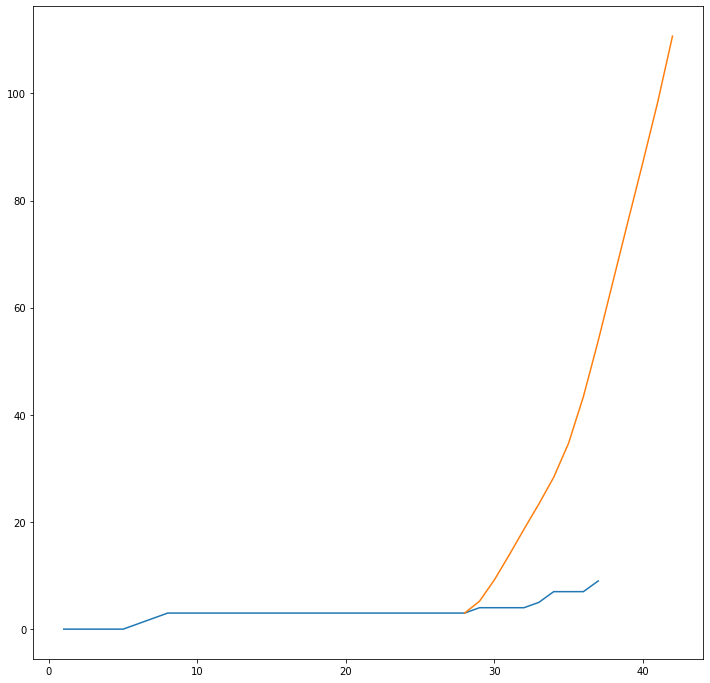

In [40]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

county = 716

d1 = deaths
x1 = np.linspace(1, d1.shape[1], d1.shape[1])
plt.plot(x1, d1[county])

s = np.argmax(np.isnan(d1[county])) - 1
d2 = dp2[county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2[s - validation_steps:], d2[s - validation_steps:])

plt.show()